# Focus Probe

This notebook trys to see what part this model looks at during prediction. 
For all three tasks.

In [1]:
import glob
import os
import random
from copyreg import pickle
import pickle as pkl
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from triton.ops import attention

from model_incremental import *
from model_dataset import TokenMap
from paths import *
from H_1_models import TwoConvNetwork
def grad_cam(model, input_tensor, target_layer, target_class):
    '''
    get one attention result(normalized) for one input and one model
    '''
    model.eval()  # Set the model to evaluation mode
    gradients = []
    activations = []
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])
    def forward_hook(module, input, output):
        activations.append(output)
    hook_b = target_layer.register_backward_hook(backward_hook)
    hook_f = target_layer.register_forward_hook(forward_hook)
    output = model(input_tensor)
    class_score = output[0, target_class]
    model.zero_grad()
    class_score.backward()
    grad = gradients[0].cpu().data.numpy()[0]
    act = activations[0].cpu().data.numpy()[0]
    hook_b.remove()
    hook_f.remove()
    weights = np.mean(grad, axis=(1, 2))
    cam = np.sum(weights[:, None, None] * act, axis=0)
    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam) if np.max(cam) != 0 else cam 

    return cam

def get_one_batch(dataloader):
    dataloader_iter = iter(dataloader)  # Create an iterator
    batch = next(dataloader_iter)      # Get the first batch
    return batch

def grad_cam_visualization(input_tensor, cam, title="Grad-CAM Heatmap",input_alpha = 0.5,output_alpha = 0.3): 
    # Plot the heatmap on the test Mel spectrogram
    plt.imshow(input_tensor.squeeze(0).squeeze(0).cpu().numpy(), aspect='auto', cmap='gray', origin='lower', alpha=input_alpha)
    plt.imshow(cam, cmap='jet', alpha=output_alpha, vmin=0, vmax=1, origin='lower')  # extent=(0, input_tensor.size(-1), 0, input_tensor.size(-2))
    plt.colorbar(label='Attention')
    plt.title(title)
    plt.show()
def grad_cam_visualization_both_camonly(cams, title="Grad-CAM Heatmap",output_alpha = 0.3): 
    
    cam1, cam2 = cams
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
   
    axs[0].imshow(cam1, cmap='jet', alpha=output_alpha, origin='lower')  # extent=(0, input_tensor.size(-1), 0, 
    
    axs[1].imshow(cam2, cmap='jet', alpha=output_alpha, origin='lower')  # extent=(0, input_tensor.size(-1), 0, 
    plt.title(title)
    plt.show()
def grad_cam_visualization_both(input_tensors, cams, title="Grad-CAM Heatmap",input_alpha = 0.5,output_alpha = 0.3): 
    # Plot the heatmap on the test Mel spectrogram
    it1, it2 = input_tensors
    cam1, cam2 = cams
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].imshow(it1.squeeze(0).squeeze(0).cpu().numpy(), aspect='auto', cmap='gray', origin='lower', alpha=input_alpha)
    axs[0].imshow(cam1, cmap='jet', alpha=output_alpha, origin='lower')  # extent=(0, input_tensor.size(-1), 0, input_tensor.size(-2))
    # axs[0].colorbar(label='Importance')
    # axs[0].title(title)
    axs[1].imshow(it2.squeeze(0).squeeze(0).cpu().numpy(), aspect='auto', cmap='gray', origin='lower', alpha=input_alpha)
    axs[1].imshow(cam2, cmap='jet', alpha=output_alpha, origin='lower')  # extent=(0, input_tensor.size(-1), 0, input_tensor.size(-2))
    # axs[1].colorbar(label='Importance')
    # axs[1].title(title)
    # plt.imshow(input_tensor.squeeze(0).squeeze(0).cpu().numpy(), aspect='auto', cmap='gray', origin='lower', alpha=0.5)
    # plt.imshow(cam, cmap='jet', alpha=0.3, vmin=0, vmax=1, origin='lower')  # extent=(0, input_tensor.size(-1), 0, input_tensor.size(-2))
    # fig.colorbar(label='Importance')
    plt.title(title)
    plt.show()

In [2]:
pre = [10,20,30,40,50,60,70,80,90,100]
total = [i for i in range(21,26)]
condition = []
for i in pre:
    for j in total:
        epoch = j*10
        if epoch >= i:
            condition.append((i,epoch))
print(condition)

[(10, 210), (10, 220), (10, 230), (10, 240), (10, 250), (20, 210), (20, 220), (20, 230), (20, 240), (20, 250), (30, 210), (30, 220), (30, 230), (30, 240), (30, 250), (40, 210), (40, 220), (40, 230), (40, 240), (40, 250), (50, 210), (50, 220), (50, 230), (50, 240), (50, 250), (60, 210), (60, 220), (60, 230), (60, 240), (60, 250), (70, 210), (70, 220), (70, 230), (70, 240), (70, 250), (80, 210), (80, 220), (80, 230), (80, 240), (80, 250), (90, 210), (90, 220), (90, 230), (90, 240), (90, 250), (100, 210), (100, 220), (100, 230), (100, 240), (100, 250)]


In [24]:
checking_domain = "pureTone" # pureTone, stress, tone

if checking_domain == "tone":
    # Setting for tone: 
    from model_dataset import ToneDatasetNew as ThisDataset
    configs = {
        "num_dataset": 50,"size_train": 1600,"size_valid": 320,"data_type": "mel",
        "total_epochs": 300, "lr": 1e-4,
        "data_type_mapper": {
            "f": "full", 
            "l": "low",
            "h": "high"}, 
        "lpp_configs": {
            "p1": 0.5, 
            "decay_rate": 0.3
        }, 
        "max_cache_size_train": 7, "max_cache_size_valid": 20, 
        "output_dim": 4, # tone: 4; tress: 3
    }
    # task
    mylist = ["1", "2", "3", "4"]# stress: ["0","1","2"] tone: ["1", "2", "3", "4"]
    train_name = "A3" # A3 -TONE, A4 -Pute tone, A5 stress
    ts_code = "1211014530"
    model_type = "twoconvCNN"
elif checking_domain == "pureTone":
    # Setting for tone: 
    from model_dataset import ToneDatasetNew as ThisDataset
    configs = {
        "num_dataset": 50,"size_train": 1600,"size_valid": 320,"data_type": "mel",
        "total_epochs": 300, "lr": 1e-4,
        "data_type_mapper": {
            "f": "full", 
            "l": "low",
            "h": "high"}, 
        "lpp_configs": {
            "p1": 0.5, 
            "decay_rate": 0.3
        },
        "max_cache_size_train": 7, "max_cache_size_valid": 20, 
        "output_dim": 4, # tone: 4; tress: 3
    }
    # task
    mylist = ["1", "2", "3", "4"]
    ts_code = "1207190600"
    train_name = "A4"
elif checking_domain == "stress":
    from model_dataset import SyllableDatasetNew as ThisDataset
    configs = {
    "num_dataset": 50,"size_train": 1600, "size_valid": 320,"data_type": "mel","total_epochs": 300,"lr": 1e-4,
    "data_type_mapper": {
        "f": "full", 
        "l": "low",
        "h": "high"
    }, 
    "lpp_configs": {
        "p1": 0.5, 
        "decay_rate": 0.3
    }, 
    "max_cache_size_train": 7, "max_cache_size_valid": 20, 
    "output_dim": 3, # tone: 4
    }
    mylist = ["0", "1", "2"]
    train_name = "A5" 
    ts_code = "0107020830"
total_epoch = 300
model_type = "twoconvCNN"
selection = "full"
pretype = "l"
posttype = "f"
valid_cache = SubsetCache(max_cache_size=configs["max_cache_size_valid"], dataset_class=ThisDataset, shuffle=False)
full_valid_cache = SubsetCache(max_cache_size=configs["max_cache_size_valid"], dataset_class=ThisDataset, shuffle=False)
mymap = TokenMap(mylist)
def get_one_dataset(dataset_id,pre_epoch,epoch,running_trial):
    ts = f"{ts_code}-{running_trial}"
    model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
    guides_dir = os.path.join(model_save_dir, "guides")
    model_save_dir_specific = os.path.join(model_save_dir, f"{model_type}-{pre_epoch}-{total_epoch-pre_epoch}", selection, f"{pretype}{posttype}")
    pool_messanger = PoolMessanger(configs["num_dataset"], configs["data_type_mapper"][pretype], configs["data_type_mapper"][posttype], guides_dir)
    # NOTE: Subset Cache, this is to manage the reading of datasets. Should be transparent to user. 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TwoConvNetwork(out_features=configs["output_dim"])
    model.to(device)
    model_path = os.path.join(model_save_dir_specific, f"{epoch}.pt")
    print(dataset_id, model_path)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    dataset_id, meta_path, data_path = pool_messanger.get_loading_params(dataset_id,
                                                                        eval_type="valid")
    valid_loader = valid_cache.get_subset(dataset_id, meta_path, data_path, mymap, shuffle=False)
    
    
    dataset_id, meta_path, data_path = pool_messanger.get_loading_params(dataset_id,
                                                                        eval_type="full_valid")
    full_valid_loader = full_valid_cache.get_subset(dataset_id, meta_path, data_path, mymap, shuffle=False)
    valid_mel, valid_tag = valid_loader.dataset.dataset, valid_loader.dataset.gt_set
    full_valid_mel, full_valid_tag = full_valid_loader.dataset.dataset, full_valid_loader.dataset.gt_set

    def get_one_attention(random_idx:int):
        its, tsgs, cams = [], [], []
        one_valid_mel, one_valid_tag = valid_loader.dataset.__getitem__(random_idx)
        one_full_valid_mel, one_full_valid_tag = full_valid_loader.dataset.__getitem__(random_idx)
        label = one_valid_tag
        one_valid_mel = one_valid_mel.unsqueeze(0)
        one_full_valid_mel = one_full_valid_mel.unsqueeze(0)
        # transfer device
        one_valid_mel = one_valid_mel.to(device)
        one_full_valid_mel = one_full_valid_mel.to(device)
        layer_idx = 0
        # Grad-CAM valid
        input_tensor = one_valid_mel.to(torch.float32)
        target_layers = [model.conv[layer_idx]]
        targets = [ClassifierOutputTarget(one_valid_tag)]
        
        # Construct the CAM object once, and then re-use it on many images.
        with GradCAM(model=model, target_layers=target_layers) as cam:
            # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            # In this example grayscale_cam has only one image in the batch:
            grayscale_cam = grayscale_cam[0, :]
            # visualization = show_cam_on_image(one_valid_mel[0, 0, :, :], grayscale_cam, use_rgb=False)
            # grad_cam_visualization(one_valid_mel, grayscale_cam, title=f"Grad-CAM Valid {one_valid_tag}")
            its.append(input_tensor.cpu().half())
            tsgs.append(cam.outputs.argmax().item())
            cams.append(grayscale_cam.astype(np.float16))
            # You can also get the model outputs without having to redo inference
            # model_outputs = cam.outputs
        
        # Grad-CAM full
        input_tensor = one_full_valid_mel.to(torch.float32)
        target_layers = [model.conv[layer_idx]]
        targets = [ClassifierOutputTarget(one_full_valid_tag)]
        
        with GradCAM(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]
            its.append(input_tensor.cpu().half())
            tsgs.append(cam.outputs.argmax().item())
            cams.append(grayscale_cam.astype(np.float16))
        return its, tsgs, cams,label
    indexes = [i for i in range(len(valid_mel))]
    input_valid_tensors = []
    cam_valid_tensors = []
    input_full_tensors = []
    cam_full_tensors = []
    valid_predicts = []
    full_predicts = []
    labels = []
    for idx in indexes:
        its, tsgs, cams,label = get_one_attention(idx)
        valid_predicts.append(tsgs[0])
        full_predicts.append(tsgs[1])
        labels.append(label)
        input_valid_tensors.append(its[0])
        input_full_tensors.append(its[1])
        cam_valid_tensors.append(cams[0])
        cam_full_tensors.append(cams[1])
    result = {
        "dataset_id":dataset_id,
         "indexes":indexes,
         "labels":labels,
        "domain":checking_domain,
        "model":model_path,
        "pre_epoch":pre_epoch,
        "total_epoch":epoch,
        "run":running_trial,
        "cam_valid_tensors":cam_valid_tensors,
        "cam_full_tensors":cam_full_tensors,
        "valid_predicts":valid_predicts,
        "full_predicts":full_predicts
    }
    return result,input_valid_tensors,input_full_tensors,labels
# ave_valid_input = torch.mean(torch.stack(input_valid_tensors), dim=0)
# ave_full_input = torch.mean(torch.stack(input_full_tensors), dim=0)
# ave_valid_cam = np.mean(cam_valid_tensors, axis=0)
# ave_full_cam = np.mean(cam_full_tensors, axis=0)
# grad_cam_visualization_both([ave_valid_input,ave_full_input], [ave_valid_cam,ave_full_cam], title=f"Grad-CAM Heatmap",input_alpha=0,output_alpha=1)

In [25]:
dataset_ids = [0,25,49] # 0,25,49
for id in dataset_ids:
    folderid = os.path.join(f'/mnt/storage/compling/proslearn/attention_check/{checking_domain}', f"dataset{id}")
    os.makedirs(folderid, exist_ok=True)
    for pre_epoch,epoch in condition:
        savename = f'{checking_domain}_dataset{id}_low{pre_epoch}e_total{epoch}e'
        runs = []
        for running_trial in [1,2,3,4,5]:
            attention_result,input_valid_tensors,input_full_tensors,labels = get_one_dataset(id,pre_epoch,epoch,running_trial)
            runs.append(attention_result)
        savepath = os.path.join(folderid, savename)
        pkl.dump(runs, open(savepath, "wb"))
    inputs = {
        "dataset_id":id,
        "domain":checking_domain,
        "input_valid_tensors":input_valid_tensors,
        "input_full_tensors":input_full_tensors,
        "labels":labels
    }
    saveinputpath = os.path.join(folderid, f"input")
    pkl.dump(inputs,open(saveinputpath, "wb"))

0 ../model_save/A4-1207190600-1/twoconvCNN-20-280/full/lf/20.pt
Filtered 21 rows out of 400 from metadata. Now 379 rows remaining.
Filtered 21 rows out of 400 from metadata. Now 379 rows remaining.
0 ../model_save/A4-1207190600-2/twoconvCNN-20-280/full/lf/20.pt
0 ../model_save/A4-1207190600-3/twoconvCNN-20-280/full/lf/20.pt
0 ../model_save/A4-1207190600-4/twoconvCNN-20-280/full/lf/20.pt
0 ../model_save/A4-1207190600-5/twoconvCNN-20-280/full/lf/20.pt
0 ../model_save/A4-1207190600-1/twoconvCNN-20-280/full/lf/30.pt
0 ../model_save/A4-1207190600-2/twoconvCNN-20-280/full/lf/30.pt
0 ../model_save/A4-1207190600-3/twoconvCNN-20-280/full/lf/30.pt
0 ../model_save/A4-1207190600-4/twoconvCNN-20-280/full/lf/30.pt
0 ../model_save/A4-1207190600-5/twoconvCNN-20-280/full/lf/30.pt
0 ../model_save/A4-1207190600-1/twoconvCNN-20-280/full/lf/50.pt
0 ../model_save/A4-1207190600-2/twoconvCNN-20-280/full/lf/50.pt
0 ../model_save/A4-1207190600-3/twoconvCNN-20-280/full/lf/50.pt
0 ../model_save/A4-1207190600-4/tw

In [27]:
#checking_domain = "pureTone"

pre = [10,20,30,40,50,60,70,80,90,100]
total = [i for i in range(1,26)]
condition = []
for i in pre:
    for j in total:
        epoch = j*10
        if epoch >= i:
            condition.append((i,epoch))
print(condition)

for dataset_id in dataset_ids:
    filenames = glob.glob(os.path.join(f"/mnt/storage/compling/proslearn/attention_check/{checking_domain}/dataset{dataset_id}", f"{checking_domain}_*"))
    inputs = pkl.load(open(os.path.join(f"/mnt/storage/compling/proslearn/attention_check/{checking_domain}/dataset{dataset_id}", "input"), "rb"))
    seed = random.randint(0,200)
    labels = None
    indexes = None
    cams_valid = {}
    cams_full = {}
    for file in filenames:
        data = pkl.load(open(file, "rb"))
        pre_epoch = data[0]['pre_epoch']
        total_epoch = data[0]['total_epoch']
        # Assuming each attention_result contains 5 results
        num_results = len(data)
        accumulated_valid_cams = None
        accumulated_full_cams = None
        if labels == None:
            labels = data[0]['labels']
            indexes = data[0]['indexes']
        for attention_result in data:
            # Get the cam_valid_tensors for each result
            cam_valid_tensors = attention_result['cam_valid_tensors']
            cam_full_tensors = attention_result['cam_full_tensors']
            # Convert list to a numpy array for easier manipulation
            cam_valid_tensors_array = np.array(cam_valid_tensors)
            cam_full_tensors_array = np.array(cam_full_tensors)
            # Accumulate the tensors
            if accumulated_valid_cams is None:
                accumulated_valid_cams = cam_valid_tensors_array
                accumulated_full_cams = cam_full_tensors_array
            else:
                accumulated_valid_cams += cam_valid_tensors_array
                accumulated_full_cams += cam_full_tensors_array
            
            
        # Calculate the average
        averaged_valid_cams = accumulated_valid_cams / num_results
        averaged_full_cams = accumulated_full_cams / num_results
        averaged_valid_cams = [averaged_valid_cams[i] for i in range(averaged_valid_cams.shape[0])]
        averaged_full_cams = [averaged_full_cams[i] for i in range(averaged_full_cams.shape[0])]
        key = f"dataset{dataset_id}_pre{pre_epoch}_total{total_epoch}"
        cams_valid[key] = averaged_valid_cams
        cams_full[key] = averaged_full_cams
        #grad_cam_visualization_both_camonly((averaged_valid_cams[seed],averaged_full_cams[seed]), title=f"Grad-CAM Heatmap",output_alpha=1)
    result = {'domain':checking_domain,
              "dataset_id":dataset_id,
              "labels":labels,
              "cams_full":cams_full,
              "cams_valid": cams_valid}
    
    pkl.dump(result,open(os.path.join(f"/mnt/storage/compling/proslearn/attention_check/{checking_domain}_dataset{dataset_id}"),"wb"))

[(10, 10), (10, 20), (10, 30), (10, 40), (10, 50), (10, 60), (10, 70), (10, 80), (10, 90), (10, 100), (10, 110), (10, 120), (10, 130), (10, 140), (10, 150), (10, 160), (10, 170), (10, 180), (10, 190), (10, 200), (10, 210), (10, 220), (10, 230), (10, 240), (10, 250), (20, 20), (20, 30), (20, 40), (20, 50), (20, 60), (20, 70), (20, 80), (20, 90), (20, 100), (20, 110), (20, 120), (20, 130), (20, 140), (20, 150), (20, 160), (20, 170), (20, 180), (20, 190), (20, 200), (20, 210), (20, 220), (20, 230), (20, 240), (20, 250), (30, 30), (30, 40), (30, 50), (30, 60), (30, 70), (30, 80), (30, 90), (30, 100), (30, 110), (30, 120), (30, 130), (30, 140), (30, 150), (30, 160), (30, 170), (30, 180), (30, 190), (30, 200), (30, 210), (30, 220), (30, 230), (30, 240), (30, 250), (40, 40), (40, 50), (40, 60), (40, 70), (40, 80), (40, 90), (40, 100), (40, 110), (40, 120), (40, 130), (40, 140), (40, 150), (40, 160), (40, 170), (40, 180), (40, 190), (40, 200), (40, 210), (40, 220), (40, 230), (40, 240), (40, 2

In [28]:
pre = [20,40,60,80,100]
post = [0,10,30,50,100]
condition = []
for i in pre:
    for j in post:
        epoch = i + j
        condition.append((i,epoch))
print(condition)

[(20, 20), (20, 30), (20, 50), (20, 70), (20, 120), (40, 40), (40, 50), (40, 70), (40, 90), (40, 140), (60, 60), (60, 70), (60, 90), (60, 110), (60, 160), (80, 80), (80, 90), (80, 110), (80, 130), (80, 180), (100, 100), (100, 110), (100, 130), (100, 150), (100, 200)]


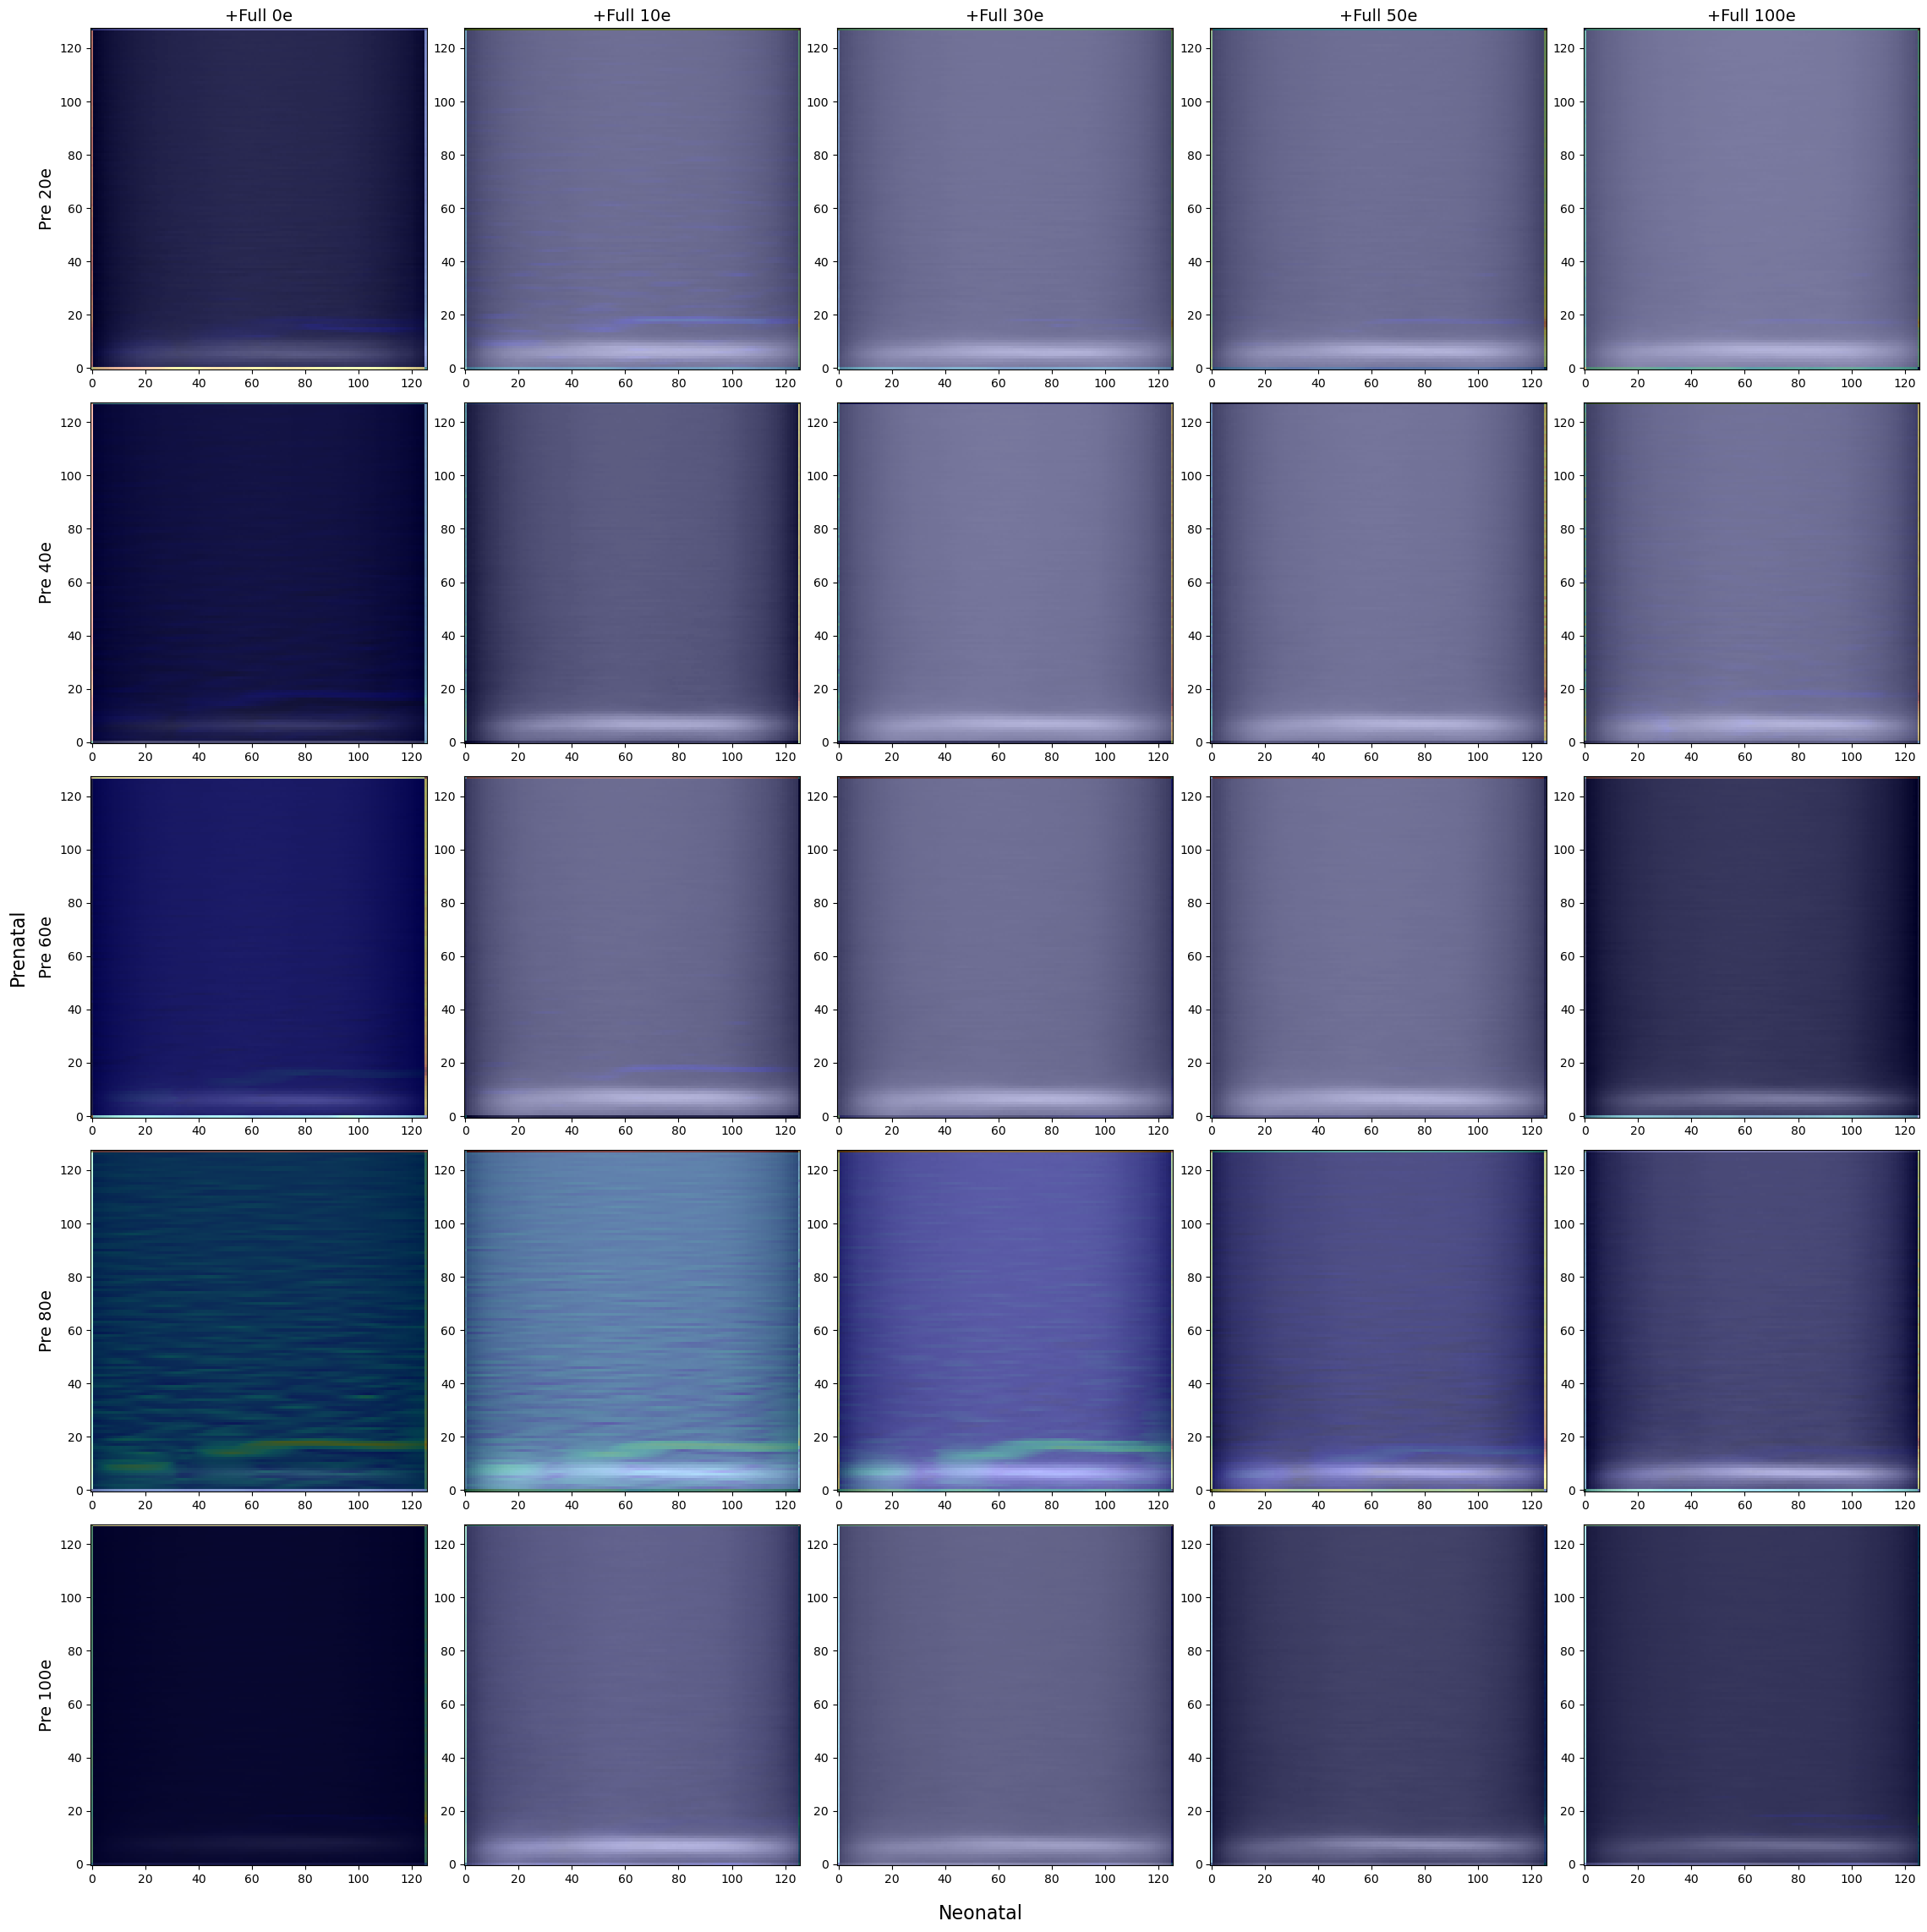

In [29]:
def grad_cam_visualization_grid(cam_dict, dataset_id,condition, seed, output_alpha=1):
    
    fig, axs = plt.subplots(len(pre), len(post), figsize=(len(pre)*5, len(post)*5))

    for index, (pre_epoch,total_epoch) in enumerate(condition):
        key = f"dataset{dataset_id}_pre{pre_epoch}_total{total_epoch}"  # Construct the key
        i = int(pre_epoch/20)-1
        j = index%5
        #print(i,j)
        if key in cam_dict:
            if seed is None:
                cam = np.sum(cam_dict[key],axis=0)
                axs[i, j].imshow(cam, cmap='jet', alpha=output_alpha, origin='lower')
            elif seed == "collasped":
                # Sum each array along the second axis (axis=1) to collapse to (128, 1)
                collapsed_arrays = [np.sum(array, axis=1, keepdims=True) for array in cam_dict[key]]
                
                # Now, sum the list of collapsed arrays to get a single (128, 1) array
                total_sum = np.sum(np.array(collapsed_arrays), axis=0)
                cam = total_sum
                axs[i, j].bar(np.arange(128), cam.flatten(), alpha=output_alpha)
            elif seed == "both":
                cam1 = np.sum(cam_dict[key],axis=0)
                axs[i,j].imshow(cam1, aspect='auto', cmap='gray', origin='lower', alpha=1)
                cam2 = cam_dict[key][100]
                axs[i, j].imshow(cam2, cmap='jet', origin='lower',alpha=0.3)
            else:
                cam= cam_dict[key][seed] # Retrieve the CAMs from the dictionary
            # Display the CAMs
                axs[i, j].imshow(cam, cmap='jet', alpha=output_alpha, origin='lower')
            #axs[i, j].set_title(f'Pre-epoch: {pre_epoch}, Total epoch: {total_epoch}')
        else:
            print(key)
            axs[i, j].text(0.5, 0.5, f'{pre_epoch}', ha='center', va='center')
            
        #axs[i, j].axis('off')  # Hide axes ticks
        
    row_labels = [f'Pre {pre_epoch}e' for pre_epoch in pre]
    col_labels = [f'+Full {post_epoch}e' for post_epoch in post]
        # Set common x and y labels for the entire figure
    fig.text(0.5, 0.04, 'Neonatal', ha='center', fontsize=16)
    fig.text(0.04, 0.5, 'Prenatal', va='center', rotation='vertical', fontsize=16)
    for ax, label in zip(axs[:, 0], row_labels):
        ax.set_ylabel(label, fontsize=14)
    for ax, label in zip(axs[0], col_labels):
        ax.set_title(label, fontsize=14)

    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust layout to make space for the labels
    plt.show()

seed = random.randint(0,200)
grad_cam_visualization_grid(cams_full, dataset_id, condition=condition,seed = "both")